UNBIASED OFFLINE POLICY EVALUATION THROUGH INVERSE PROPENSITY SCORES

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tensorflow as tf
import tensorflow_probability as tfp
import gpytorch
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from scipy.stats import gamma, norm, beta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings



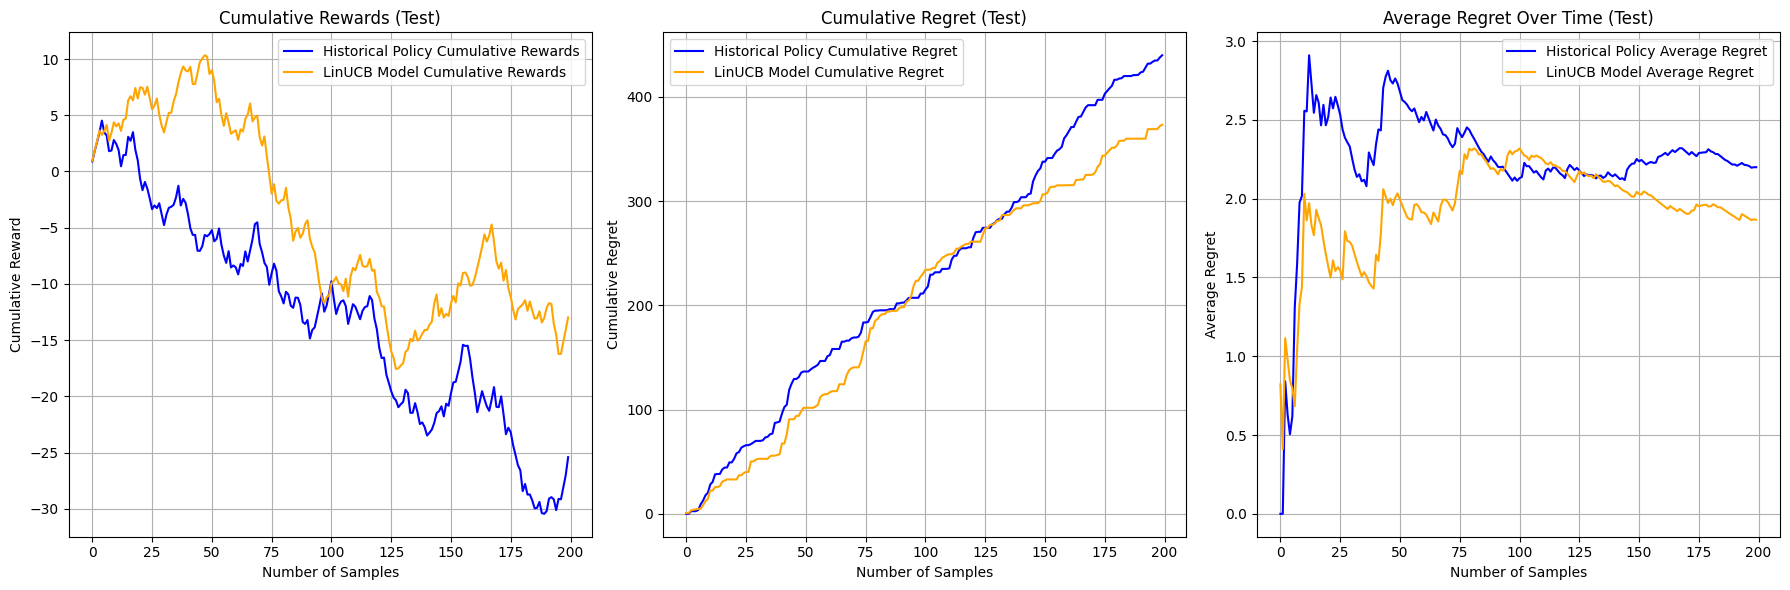

Train IPS value of Historical Policy: -2.35
Train IPS value of Evaluation Policy (LinUCB): -0.04
Test IPS value of Historical Policy: -2.9
Test IPS value of Evaluation Policy (LinUCB): -0.59
The evaluation policy (LinUCB) is expected to perform better than the historical policy on the test set.


In [3]:
## LINUCB BACKTESTING WITH INVERSE PROPENSITY SCORES  

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(6)

# Simulate the data
n_samples = 1000
context_dim = 10 
n_actions = 3   ## <=5 



# Define reward functions
def reward_action_1(context):
    return np.sum(np.sin(2 * np.pi * context))

def reward_action_2(context):
    return np.sum(np.sin(3 * np.pi * context) + np.cos(1.5 * np.pi * context))

def reward_action_3(context):
    return np.sum(np.sin(1.5 * np.pi * context) + np.cos(3 * np.pi * context))

def reward_action_4(context):
    return np.sum(np.tan(0.5 * np.pi * context))

def reward_action_5(context):
    return np.sum(np.exp(-context**2))

# Generate rewards based on the context and the action taken
def generate_rewards(contexts, actions, n_actions):
    rewards = np.zeros(len(actions))
    for i in range(len(actions)):
        if actions[i] == 0:
            rewards[i] = reward_action_1(contexts[i])
        elif actions[i] == 1:
            rewards[i] = reward_action_2(contexts[i])
        elif actions[i] == 2:
            rewards[i] = reward_action_3(contexts[i])
        elif actions[i] == 3:
            rewards[i] = reward_action_4(contexts[i])
        elif actions[i] == 4:
            rewards[i] = reward_action_5(contexts[i])
        else:
            raise ValueError("Action index out of range")
    return rewards



# Simulate historical data using actual propensities from historical actions
def simulate_historical_data(total_samples, context_dim, n_actions):
    # Generate random contexts
    contexts = np.random.uniform(-1, 1, size=(total_samples, context_dim))
    
    # Simulate historical actions based on a certain action distribution
    actions = np.random.randint(0, n_actions, size=total_samples)
    
    # Generate rewards based on contexts and actions
    rewards = generate_rewards(contexts, actions, n_actions)
    
    # Estimate the propensities from the historical action frequencies
    action_freq = np.bincount(actions, minlength=n_actions) / total_samples
    propensities = action_freq[actions]  # Use action frequencies to define propensities for each action
    
    return contexts, actions, rewards, propensities



# Find the best action for each context (optimal policy)
def find_optimal_actions(contexts, n_actions):
    optimal_rewards = np.zeros((contexts.shape[0], n_actions))
    for action in range(n_actions):
        optimal_rewards[:, action] = np.apply_along_axis(lambda c: reward_action_1(c) if action == 0 
                                                        else reward_action_2(c) if action == 1 
                                                        else reward_action_3(c) if action == 2 
                                                        else reward_action_4(c) if action == 3 
                                                        else reward_action_5(c), 1, contexts)
    return np.argmax(optimal_rewards, axis=1), np.max(optimal_rewards, axis=1)

# Step 2: Implement LinUCB Evaluation Policy
class LinUCB:
    def __init__(self, n_actions, context_dim, alpha=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha
        self.A = [np.identity(context_dim) for _ in range(n_actions)]
        self.b = [np.zeros((context_dim, 1)) for _ in range(n_actions)]

    def select_action(self, context):
        ucb_values = np.zeros(self.n_actions)
        context = context.reshape(-1, 1)
        for a in range(self.n_actions):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv.dot(self.b[a])
            ucb_values[a] = theta.T.dot(context) + self.alpha * np.sqrt(context.T.dot(A_inv).dot(context))
        return np.argmax(ucb_values)

    def update(self, context, action, reward):
        context = context.reshape(-1, 1)
        self.A[action] += context.dot(context.T)
        self.b[action] += reward * context

# IPS Calculation
def ips_historical(contexts, actions, rewards, propensities):
    ips = 0
    for i in range(len(actions)):
        ips += rewards[i] / propensities[i]
    return ips / len(actions)

def ips_evaluation(contexts, actions, rewards, propensities, linucb):
    ips = 0
    for i in range(len(actions)):
        action_eval = linucb.select_action(contexts[i])
        if actions[i] == action_eval:
            ips += rewards[i] / propensities[i]
    return ips / len(actions)

# Calculate regret
def calculate_regret(contexts, actions, rewards, model):
    optimal_actions, optimal_rewards = find_optimal_actions(contexts, n_actions)
    model_rewards = np.array([reward_action_1(c) if model.select_action(c) == 0
                              else reward_action_2(c) if model.select_action(c) == 1 
                              else reward_action_3(c) if model.select_action(c) == 2 
                              else reward_action_4(c) if model.select_action(c) == 3 
                              else reward_action_5(c) for c in contexts])
    regret = np.sum(optimal_rewards - model_rewards)
    return regret


contexts, actions, rewards, propensities = simulate_historical_data(n_samples, context_dim, n_actions)

# Step 3: Train-Test Split
contexts_train, contexts_test, actions_train, actions_test, rewards_train, rewards_test, propensities_train, propensities_test = train_test_split(
    contexts, actions, rewards, propensities, test_size=0.2, random_state=42
)

# Initialize LinUCB
linucb = LinUCB(n_actions=n_actions, context_dim=context_dim, alpha=1.0)

# Train LinUCB on the training set
for i in range(len(actions_train)):
    linucb.update(contexts_train[i], actions_train[i], rewards_train[i])

# Calculate IPS on the training set
ips_historical_value_train = ips_historical(contexts_train, actions_train, rewards_train, propensities_train)
ips_evaluation_value_train = ips_evaluation(contexts_train, actions_train, rewards_train, propensities_train, linucb)

# Calculate IPS on the test set
ips_historical_value_test = ips_historical(contexts_test, actions_test, rewards_test, propensities_test)
ips_evaluation_value_test = ips_evaluation(contexts_test, actions_test, rewards_test, propensities_test, linucb)

# Calculate cumulative rewards and regrets for historical and model
cumulative_rewards_historical = np.cumsum([generate_rewards(c, [a], n_actions)[0] for c, a in zip(contexts_test, actions_test)])
cumulative_rewards_model = np.cumsum([generate_rewards(c, [linucb.select_action(c)], n_actions)[0] for c in contexts_test])

# Calculate cumulative regret
optimal_actions_test, optimal_rewards_test = find_optimal_actions(contexts_test, n_actions)
cumulative_regret_historical = np.cumsum(optimal_rewards_test - [reward_action_1(c) if a == 0 
                                                                  else reward_action_2(c) if a == 1 
                                                                  else reward_action_3(c) if a == 2 
                                                                  else reward_action_4(c) if a == 3 
                                                                  else reward_action_5(c) for c, a in zip(contexts_test, actions_test)])

cumulative_regret_model = np.cumsum(optimal_rewards_test - [reward_action_1(c) if linucb.select_action(c) == 0 
                                                            else reward_action_2(c) if linucb.select_action(c) == 1 
                                                            else reward_action_3(c) if linucb.select_action(c) == 2 
                                                            else reward_action_4(c) if linucb.select_action(c) == 3 
                                                            else reward_action_5(c) for c in contexts_test])

# Calculate average regret over time
average_regret_historical = np.cumsum(optimal_rewards_test - [reward_action_1(c) if a == 0 
                                                               else reward_action_2(c) if a == 1 
                                                               else reward_action_3(c) if a == 2 
                                                               else reward_action_4(c) if a == 3 
                                                               else reward_action_5(c) for c, a in zip(contexts_test, actions_test)]) / (np.arange(len(optimal_rewards_test)) + 1)

average_regret_model = np.cumsum(optimal_rewards_test - [reward_action_1(c) if linucb.select_action(c) == 0 
                                                          else reward_action_2(c) if linucb.select_action(c) == 1 
                                                          else reward_action_3(c) if linucb.select_action(c) == 2 
                                                          else reward_action_4(c) if linucb.select_action(c) == 3 
                                                          else reward_action_5(c) for c in contexts_test]) / (np.arange(len(optimal_rewards_test)) + 1)

# Plot cumulative rewards, regrets, and average regret
plt.figure(figsize=(18, 6))

# Plot cumulative rewards
plt.subplot(1, 3, 1)
plt.plot(cumulative_rewards_historical, label="Historical Policy Cumulative Rewards", color='blue')
plt.plot(cumulative_rewards_model, label="LinUCB Model Cumulative Rewards", color='orange')
plt.title("Cumulative Rewards (Test)")
plt.xlabel("Number of Samples")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)

# Plot cumulative regret
plt.subplot(1, 3, 2)
plt.plot(cumulative_regret_historical, label="Historical Policy Cumulative Regret", color='blue')
plt.plot(cumulative_regret_model, label="LinUCB Model Cumulative Regret", color='orange')
plt.title("Cumulative Regret (Test)")
plt.xlabel("Number of Samples")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)

# Plot average regret
plt.subplot(1, 3, 3)
plt.plot(average_regret_historical, label="Historical Policy Average Regret", color='blue')
plt.plot(average_regret_model, label="LinUCB Model Average Regret", color='orange')
plt.title("Average Regret Over Time (Test)")
plt.xlabel("Number of Samples")
plt.ylabel("Average Regret")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print results
print(f"Train IPS value of Historical Policy: {np.round(ips_historical_value_train,2)}")
print(f"Train IPS value of Evaluation Policy (LinUCB): {np.round(ips_evaluation_value_train,2)}")

print(f"Test IPS value of Historical Policy: {np.round(ips_historical_value_test,2)}")
print(f"Test IPS value of Evaluation Policy (LinUCB): {np.round(ips_evaluation_value_test,2)}")

if ips_evaluation_value_test > ips_historical_value_test:
    print("The evaluation policy (LinUCB) is expected to perform better than the historical policy on the test set.")
else:
    print("The historical policy is expected to perform better than the evaluation policy (LinUCB) on the test set.")


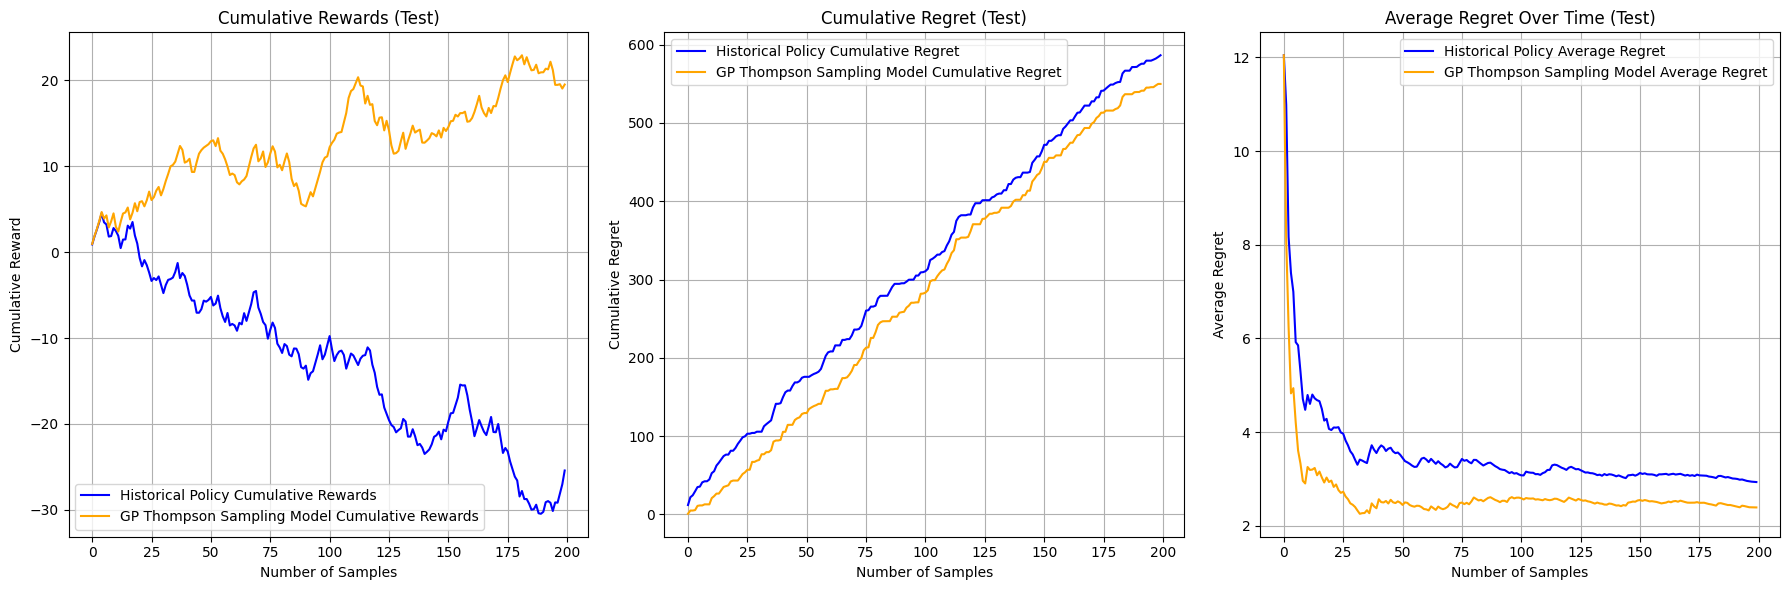

Train IPS value of Historical Policy: -2.35
Train IPS value of Evaluation Policy (GP Thompson Sampling): 1.91
Test IPS value of Historical Policy: -2.9
Test IPS value of Evaluation Policy (GP Thompson Sampling): -0.33
The evaluation policy (GP Thompson Sampling) is expected to perform better than the historical policy on the test set.


In [4]:
# THOMPSON SAMPLING BACKTESTING WITH INVERSE PROPENSITY SCORES

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(6)

# Simulate the data
n_samples = 1000
context_dim = 10
n_actions = 3   ## <=5



# Define reward functions
def reward_action_1(context):
    return np.sum(np.sin(2 * np.pi * context))

def reward_action_2(context):
    return np.sum(np.sin(3 * np.pi * context) + np.cos(1.5 * np.pi * context))

def reward_action_3(context):
    return np.sum(np.sin(1.5 * np.pi * context) + np.cos(3 * np.pi * context))

def reward_action_4(context):
    return np.sum(np.tan(0.5 * np.pi * context))

def reward_action_5(context):
    return np.sum(np.exp(-context**2))

# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, lengthscale=1.0, outputscale=1.0):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, lengthscale=lengthscale)
        )
        self.covar_module.outputscale = outputscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Define the GP Thompson Sampling class
class GPThompsonSampling:
    def __init__(self, n_actions, context_dim, num_samples=100, batch_size=10, lengthscale=1.0, outputscale=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.lengthscale = lengthscale
        self.outputscale = outputscale
        self.models = [None] * n_actions
        self.likelihoods = [gpytorch.likelihoods.GaussianLikelihood() for _ in range(n_actions)]

    def update(self, actions, rewards, contexts):
        contexts = torch.tensor(contexts, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)

        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum().item() == 0:
                continue

            X_train_action = contexts[indices]
            y_train_action = rewards[indices]

            self.models[action] = ExactGPModel(X_train_action, y_train_action, self.likelihoods[action], 
                                               lengthscale=self.lengthscale, outputscale=self.outputscale)
            self.models[action].train()
            optimizer = torch.optim.Adam(self.models[action].parameters(), lr=0.1)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihoods[action], self.models[action])

            for _ in range(50):  # Number of training epochs
                optimizer.zero_grad()
                output = self.models[action](X_train_action)
                loss = -mll(output, y_train_action)
                loss.backward()
                optimizer.step()

    def predict(self, context):
        context = torch.tensor(context, dtype=torch.float32)
        means = np.zeros((context.shape[0], self.n_actions))
        stddevs = np.zeros((context.shape[0], self.n_actions))

        for batch_start in range(0, context.shape[0], self.batch_size):
            context_batch = context[batch_start:batch_start + self.batch_size]
            for action in range(self.n_actions):
                if self.models[action] is None:
                    means[batch_start:batch_start + self.batch_size, action] = np.random.randn(context_batch.shape[0])
                    stddevs[batch_start:batch_start + self.batch_size, action] = np.ones(context_batch.shape[0])
                else:
                    self.models[action].eval()
                    gp_samples = self.sample_from_gp_posterior(self.models[action], context_batch, self.num_samples)
                    means[batch_start:batch_start + self.batch_size, action] = gp_samples.mean(dim=0).numpy()
                    stddevs[batch_start:batch_start + self.batch_size, action] = gp_samples.std(dim=0).numpy()
        return means, stddevs

    def sample_from_gp_posterior(self, model, context, num_samples):
        with torch.no_grad():
            posterior = model(context)
            samples = posterior.sample(sample_shape=torch.Size([num_samples]))
        return samples
    
    def select_action(self, context):
        # Convert context to a PyTorch tensor and reshape for a single sample
        # Check if context is already a tensor
       
        context_tensor = torch.tensor(context, dtype=torch.float32).unsqueeze(0).clone().detach()

        # Get predicted means and standard deviations from the GP models for each action
        means, stddevs = self.predict(context_tensor)

        # Sample from a normal distribution for each action's predicted reward
        sampled_rewards = np.random.normal(loc=means[0], scale=stddevs[0])

        # Select the action with the highest sampled reward
        best_action = np.argmax(sampled_rewards)

        return best_action




# Generate rewards based on the context and the action taken
def generate_rewards(contexts, actions, n_actions):
    rewards = np.zeros(len(actions))
    for i in range(len(actions)):
        if actions[i] == 0:
            rewards[i] = reward_action_1(contexts[i])
        elif actions[i] == 1:
            rewards[i] = reward_action_2(contexts[i])
        elif actions[i] == 2:
            rewards[i] = reward_action_3(contexts[i])
        elif actions[i] == 3:
            rewards[i] = reward_action_4(contexts[i])
        elif actions[i] == 4:
            rewards[i] = reward_action_5(contexts[i])
        else:
            raise ValueError("Action index out of range")
    return rewards



# Simulate historical data using actual propensities from historical actions
def simulate_historical_data(total_samples, context_dim, n_actions):
    # Generate random contexts
    contexts = np.random.uniform(-1, 1, size=(total_samples, context_dim))
    
    # Simulate historical actions based on a certain action distribution
    actions = np.random.randint(0, n_actions, size=total_samples)
    
    # Generate rewards based on contexts and actions
    rewards = generate_rewards(contexts, actions, n_actions)
    
    # Estimate the propensities from the historical action frequencies
    action_freq = np.bincount(actions, minlength=n_actions) / total_samples
    propensities = action_freq[actions]  # Use action frequencies to define propensities for each action
    
    return contexts, actions, rewards, propensities


# Find the best action for each context (optimal policy)
def find_optimal_actions(contexts, n_actions):
    optimal_rewards = np.zeros((contexts.shape[0], n_actions))
    for action in range(n_actions):
        optimal_rewards[:, action] = np.apply_along_axis(lambda c: reward_action_1(c) if action == 0 
                                                        else reward_action_2(c) if action == 1 
                                                        else reward_action_3(c) if action == 2 
                                                        else reward_action_4(c) if action == 3 
                                                        else reward_action_5(c), 1, contexts)
    return np.argmax(optimal_rewards, axis=1), np.max(optimal_rewards, axis=1)

# IPS Calculation
def ips_historical(contexts, actions, rewards, propensities):
    ips = 0
    for i in range(len(actions)):
        ips += rewards[i] / propensities[i]
    return ips / len(actions)

def ips_evaluation(contexts, actions, rewards, propensities, model):
    ips = 0
    for i in range(len(actions)):
        means, _ = model.predict(contexts[i].reshape(1, -1))
        action_eval = np.argmax(means)
        if actions[i] == action_eval:
            ips += rewards[i] / propensities[i]
    return ips / len(actions)



contexts, actions, rewards, propensities = simulate_historical_data(n_samples, context_dim, n_actions)

# Step 3: Train-Test Split
contexts_train, contexts_test, actions_train, actions_test, rewards_train, rewards_test, propensities_train, propensities_test = train_test_split(
    contexts, actions, rewards, propensities, test_size=0.2, random_state=42
)

# Initialize GP Thompson Sampling
gp_ts = GPThompsonSampling(n_actions=n_actions, context_dim=context_dim, num_samples=100)

# Train GP Thompson Sampling on the training set
gp_ts.update(actions_train, rewards_train, contexts_train)

# Calculate IPS on the training set
ips_historical_value_train = ips_historical(contexts_train, actions_train, rewards_train, propensities_train)
ips_evaluation_value_train = ips_evaluation(contexts_train, actions_train, rewards_train, propensities_train, gp_ts)

# Calculate IPS on the test set
ips_historical_value_test = ips_historical(contexts_test, actions_test, rewards_test, propensities_test)
ips_evaluation_value_test = ips_evaluation(contexts_test, actions_test, rewards_test, propensities_test, gp_ts)



# Cumulative rewards and regrets
cumulative_rewards_historical = np.cumsum([generate_rewards(c, [a], n_actions)[0] for c, a in zip(contexts_test, actions_test)])
cumulative_rewards_model = np.cumsum([generate_rewards(c, [gp_ts.select_action(c)], n_actions)[0] for c in contexts_test])

optimal_actions_test, optimal_rewards_test = find_optimal_actions(contexts_test, n_actions)
cumulative_regret_historical = np.cumsum(optimal_rewards_test - [reward_action_1(c) if a == 0 
                                                                  else reward_action_2(c) for c, a in zip(contexts_test, actions_test)])
cumulative_regret_model = np.cumsum(optimal_rewards_test - [reward_action_1(c) if gp_ts.select_action(c) == 0 
                                                            else reward_action_2(c) for c in contexts_test])

# Average regret over time
average_regret_historical = np.cumsum(optimal_rewards_test - [reward_action_1(c) if a == 0 
                                                               else reward_action_2(c) for c, a in zip(contexts_test, actions_test)]) / (np.arange(len(optimal_rewards_test)) + 1)

average_regret_model = np.cumsum(optimal_rewards_test - [reward_action_1(c) if gp_ts.select_action(c) == 0 
                                                          else reward_action_2(c) for c in contexts_test]) / (np.arange(len(optimal_rewards_test)) + 1)

# Plot cumulative rewards, regrets, and average regret
plt.figure(figsize=(18, 6))

# Plot cumulative rewards
plt.subplot(1, 3, 1)
plt.plot(cumulative_rewards_historical, label="Historical Policy Cumulative Rewards", color='blue')
plt.plot(cumulative_rewards_model, label="GP Thompson Sampling Model Cumulative Rewards", color='orange')
plt.title("Cumulative Rewards (Test)")
plt.xlabel("Number of Samples")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)

# Plot cumulative regret
plt.subplot(1, 3, 2)
plt.plot(cumulative_regret_historical, label="Historical Policy Cumulative Regret", color='blue')
plt.plot(cumulative_regret_model, label="GP Thompson Sampling Model Cumulative Regret", color='orange')
plt.title("Cumulative Regret (Test)")
plt.xlabel("Number of Samples")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)

# Plot average regret
plt.subplot(1, 3, 3)
plt.plot(average_regret_historical, label="Historical Policy Average Regret", color='blue')
plt.plot(average_regret_model, label="GP Thompson Sampling Model Average Regret", color='orange')
plt.title("Average Regret Over Time (Test)")
plt.xlabel("Number of Samples")
plt.ylabel("Average Regret")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Print results
print(f"Train IPS value of Historical Policy: {np.round(ips_historical_value_train,2)}")
print(f"Train IPS value of Evaluation Policy (GP Thompson Sampling): {np.round(ips_evaluation_value_train,2)}")

print(f"Test IPS value of Historical Policy: {np.round(ips_historical_value_test,2)}")
print(f"Test IPS value of Evaluation Policy (GP Thompson Sampling): {np.round(ips_evaluation_value_test,2)}")

if ips_evaluation_value_test > ips_historical_value_test:
    print("The evaluation policy (GP Thompson Sampling) is expected to perform better than the historical policy on the test set.")
else:
    print("The historical policy is expected to perform better than the evaluation policy (GP Thompson Sampling) on the test set.")
